In [1]:
%load_ext autoreload


In [2]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt
import cmasher as cmr
import corner    
import multiprocessing as mpr
mpr.set_start_method('fork')
#import gp_init_threads as th_init
from all_prof_functions import (run_each_gp, plot_recon_profs)

%aimport -os -np -plt -cmr -mpr -corner
%autoreload 2


In [3]:
# Set up some plotting stuff
plt.rc('savefig', bbox='tight')
use_bk_bgd = True #### Change this to use white backgrounds for plots  #####
if use_bk_bgd:
    plot_style = 'dark_background'
    # The CMasher package provides lots of lovely colour maps; chroma is a handy sequential cmap
    cmap = cmr.chroma_r
    c1 = cmap(0.0)
    c2 = cmap(0.1)
    c3 = cmap(0.33)
    c4 = cmap(0.55)
    c5 = cmap(0.68)
    c6 = cmap(0.815)

else:
    plot_style = 'default'
    cmap = cmr.chroma
    c1 = cmap(0.0)
    c2 = cmap(0.3)
    c3 = cmap(0.53)
    c4 = cmap(0.65)
    c5 = cmap(0.78)
    c6 = cmap(0.915)


The following cell contains variables describing the dataset and where the data are located. Change them as needed. 

In [4]:
data_dir = '/home/s86932rs/research/nudot_stuff/'
plots_dir = os.path.join(data_dir, 'plots')
psr = 'J2043+2740'
freq = 1400
be = 'afb'


In [5]:
be = be.lower()
BE = be.upper()
npz_file = os.path.join(data_dir, psr+'_{}_eigs.npz'.format(freq))
if not os.path.exists(npz_file):
    raise(RuntimeError("File containing eigenvalues does not exist"))

nudot_file = os.path.join(data_dir, psr+"_nudot_gp.txt") # contains columns of MJD, nudot, uncertainty
if not os.path.exists(nudot_file):
    raise(RuntimeError("File containing nu-dot GPs does not exist"))


In [6]:
exist_AFB = True
exist_DFB = True
with np.load(npz_file) as d:
    if 'AFB_errs' in d.keys():
        AFB_errs = d['AFB_errs']
        AFB_mean = d['AFB_mean']
        AFB_eigval = d['AFB_values']
        AFB_eigvec = d['AFB_vectors']
        AFB_eigval_bin = d['AFB_bin_vals']
        AFB_mjds = d['AFB_mjds']
        AFB_mjds_bin = d['AFB_bin_mjds']
        AFB_rms = d['AFB_rms']
    else:
        exist_AFB = False
        
    if 'DFB_errs' in d.keys():
        DFB_errs = d['DFB_errs']
        DFB_mean = d['DFB_mean']
        DFB_eigval = d['DFB_values']
        DFB_eigvec = d['DFB_vectors']
        DFB_eigval_bin = d['DFB_bin_vals']
        DFB_mjds = d['DFB_mjds']
        DFB_mjds_bin = d['DFB_bin_mjds']
        DFB_rms = d['DFB_rms']
    else:
        exist_DFB = False
        
    val_bin_len = d['val_bin_len']
    val_bin_overlap = d['val_bin_lap']

print("Binning was done with a length scale of {}.".format(val_bin_len))
if exist_AFB:
    print("The shape of the AFB eigval array is {}.".format(AFB_eigval.shape))
    if len(AFB_errs) == AFB_eigval.shape[0] and len(AFB_mean) == AFB_eigvec.shape[1] and AFB_eigval.shape[1] == AFB_eigvec.shape[0] \
        and AFB_eigval.shape[0] == len(AFB_mjds) and AFB_eigval.shape[0] == len(AFB_rms) and AFB_eigval_bin.shape[0] == len(AFB_mjds_bin):
        print("All AFB shapes and lengths agree")
    else:
        print("WARNING: Lengths and shapes for AFB do not agree!")
    
if exist_DFB:
    print("The shape of the DFB eigval array is {}.".format(DFB_eigval.shape))
    if len(DFB_errs) == DFB_eigval.shape[0] and len(DFB_mean) == DFB_eigvec.shape[1] and DFB_eigval.shape[1] == DFB_eigvec.shape[0] \
        and DFB_eigval.shape[0] == len(DFB_mjds) and DFB_eigval.shape[0] == len(DFB_rms) and DFB_eigval_bin.shape[0] == len(DFB_mjds_bin):
        print("All DFB shapes and lengths agree")
    else:
        print("WARNING: Lengths and shapes for DFB do not agree!")


Binning was done with a length scale of 200.
The shape of the AFB eigval array is (274, 30).
All AFB shapes and lengths agree
The shape of the DFB eigval array is (376, 30).
All DFB shapes and lengths agree


<Figure size 640x480 with 0 Axes>

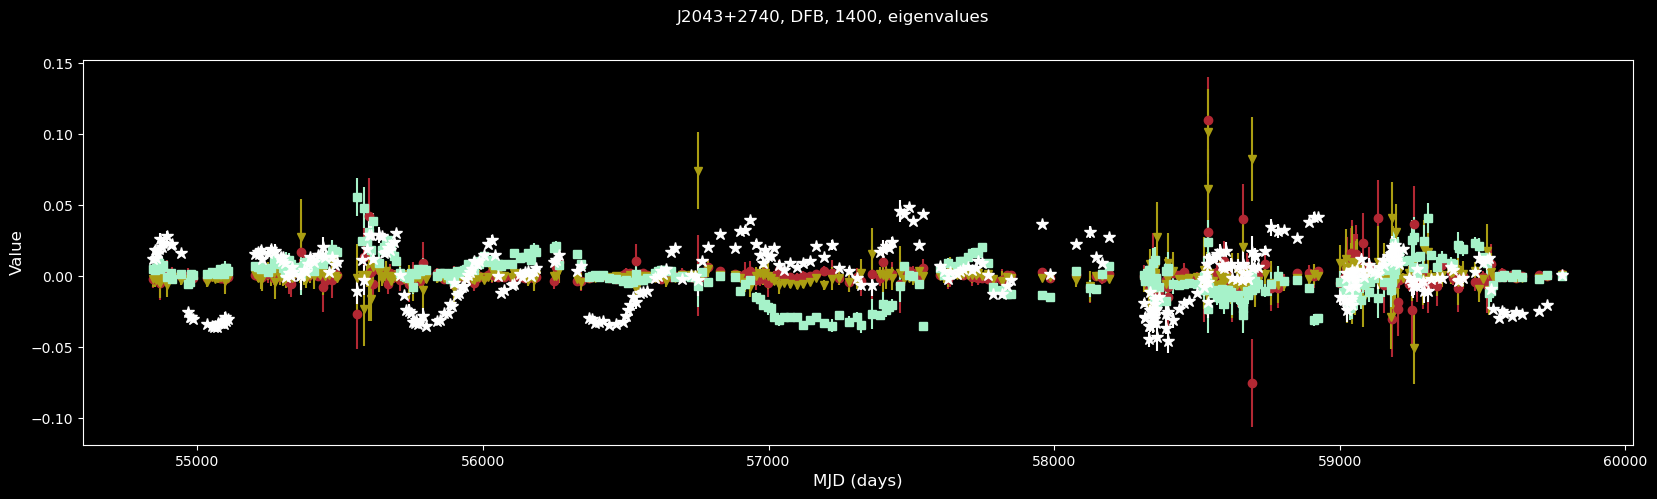

In [7]:
if exist_DFB and True:
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(figsize=(20, 5))
        fig.suptitle("{}, DFB, {}, eigenvalues".format(psr, freq))
        ax1 = fig.gca()
        ax1.errorbar(DFB_mjds, DFB_eigval[:,3], yerr=DFB_errs[:,3], fmt='o', ecolor=c4, mec=c4, mfc=c4)
        ax1.errorbar(DFB_mjds, DFB_eigval[:,2], yerr=DFB_errs[:,2], fmt='v', ecolor=c3, mec=c3, mfc=c3)
        ax1.errorbar(DFB_mjds, DFB_eigval[:,1], yerr=DFB_errs[:,1], fmt='s', ecolor=c2, mec=c2, mfc=c2)
        ax1.errorbar(DFB_mjds, DFB_eigval[:,0], yerr=DFB_errs[:,0], fmt='*', ecolor=c1, mec=c1, mfc=c1, ms=9)
        ax1.set_xlabel('MJD (days)', fontsize=12)
        ax1.set_ylabel('Value', fontsize=12)


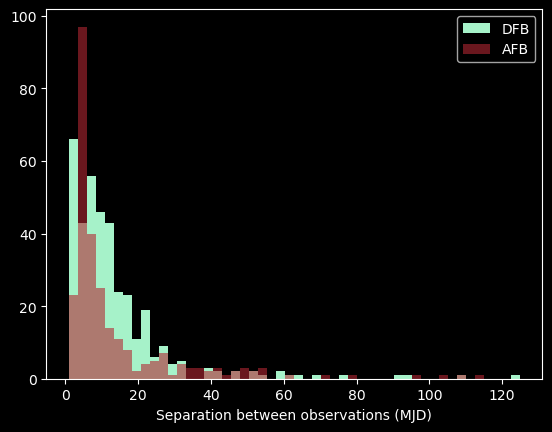

In [8]:
with plt.style.context(plot_style):
    plt.clf()
    if exist_DFB:
        _, bins, _ = plt.hist(DFB_mjds[1:] - DFB_mjds[:-1], bins=50, color=c2, label='DFB')
    else:
        bins = 50
    
    if exist_AFB:
        _ = plt.hist(AFB_mjds[1:] - AFB_mjds[:-1], bins=bins, alpha=0.6, color=c4, label='AFB')
    
    if exist_AFB or exist_DFB:
        plt.xlabel("Separation between observations (MJD)")
        plt.legend()
        plt.show()


In [9]:
# read in the MJDs from the nudot GP file to make alignment (for finding correlations) easier
nudot_mjds = np.loadtxt(nudot_file, unpack=True, usecols=(0,))
avg_sep = np.mean(nudot_mjds[1:] - nudot_mjds[:-1]) # separation between nudot MJDs
if exist_AFB:
    nudot_min = min(nudot_mjds)
    nudot_max = max(nudot_mjds)
    afb_min = min(AFB_mjds)
    afb_max = max(AFB_mjds)
    if nudot_min > afb_min:
        num_pre = int(np.ceil((nudot_min - afb_min)/avg_sep)) # number of points needed to fill
        new_min = nudot_min - avg_sep*num_pre # shift the minimum to use an integer
        pre_mjds = np.linspace(new_min, nudot_min, num_pre, endpoint=False)
        nudot_mjds = np.append(pre_mjds, nudot_mjds)
        
    if nudot_max < afb_max:
        num_post = int(np.ceil((afb_max - nudot_max)/avg_sep)) # number of points needed to fill
        new_max = nudot_max + avg_sep*num_post # shift the maximum to use an integer
        post_mjds = np.linspace(nudot_max, new_max, num_post, endpoint=False)
        nudot_mjds = np.append(nudot_mjds, post_mjds)

    AFB_mjds_pred = nudot_mjds[nudot_mjds <= max(AFB_mjds)+1]
        
if exist_DFB:
    nudot_min = min(nudot_mjds)
    nudot_max = max(nudot_mjds)
    dfb_min = min(DFB_mjds)
    dfb_max = max(DFB_mjds)
    if nudot_min > dfb_min:
        num_pre = int(np.ceil((nudot_min - dfb_min)/avg_sep)) # number of points needed to fill
        new_min = nudot_min - avg_sep*num_pre # shift the minimum to use an integer
        pre_mjds = np.linspace(new_min, nudot_min, num_pre, endpoint=False)
        nudot_mjds = np.append(pre_mjds, nudot_mjds)
    
    if nudot_max < dfb_max:
        num_post = int(np.ceil((dfb_max - nudot_max)/avg_sep)) # number of points needed to fill
        new_max = nudot_max + avg_sep*num_post # shift the maximum to use an integer
        post_mjds = np.linspace(nudot_max, new_max, num_post, endpoint=False)
        nudot_mjds = np.append(nudot_mjds, post_mjds)

    DFB_mjds_pred = nudot_mjds[nudot_mjds >= min(DFB_mjds)-1]
    
print("The MJDs for the GP prediction span from {:.5f} to {:.5f} with an average separation of {:.3f}".format(min(nudot_mjds), max(nudot_mjds), avg_sep))


The MJDs for the GP prediction span from 50255.39145 to 59779.57537 with an average separation of 1.015


Running GP for DFB data
The minimum length scale for DFB is 57.61
Subtracting 54845 from MJDs (will return true MJD values)
The initial parameter vector is [ 0.00000000e+00  6.20132379e+00 -3.94277926e+00  3.02653883e-18]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 87.34it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 86.86it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:09<00:00, 72.12it/s]


The array of autocorrelation times is [49.79065314 50.04697923 57.92110358 45.74331995]


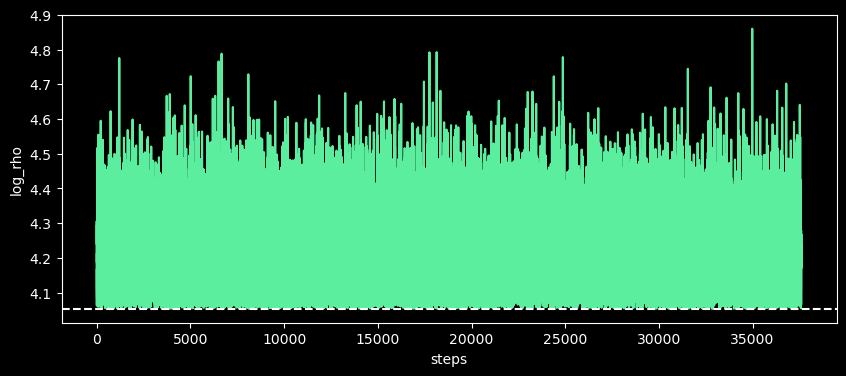

The bounds returned by the attribute are [(-15, 15), (4.053621246253011, 7.810761705902729), (-15, 15), (None, None)]
The 2nd lower bound was breached, reaching a min. of -29.99


<Figure size 640x480 with 0 Axes>

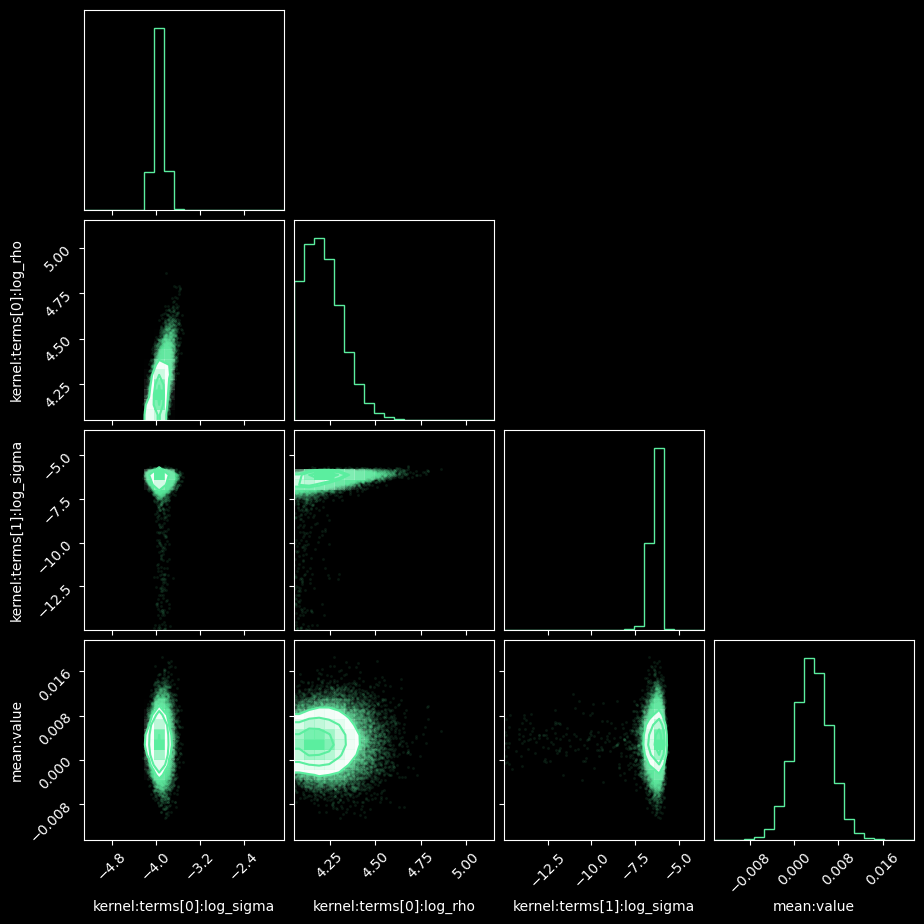

The initial parameter vector is [ 0.00000000e+00  6.20132379e+00 -4.30202464e+00  2.95272081e-18]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 69.18it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 66.91it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:12<00:00, 68.56it/s]


The array of autocorrelation times is [52.17855244 56.56837989 67.93082331 49.64198415]


<Figure size 640x480 with 0 Axes>

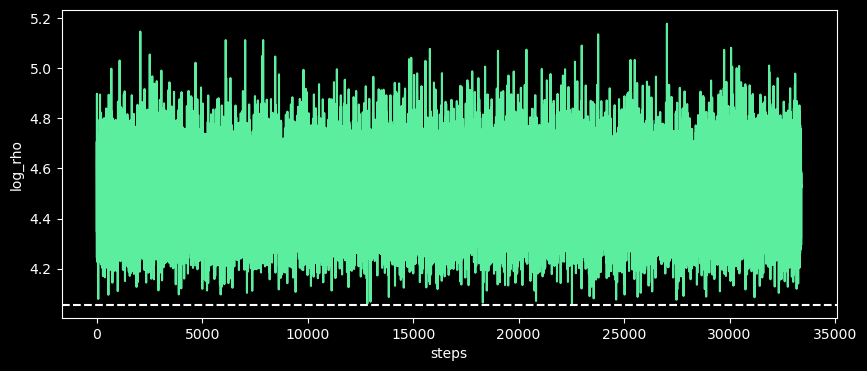

The bounds returned by the attribute are [(-15, 15), (4.053621246253011, 7.810761705902729), (-15, 15), (None, None)]
The 2nd lower bound was breached, reaching a min. of -30.00


<Figure size 640x480 with 0 Axes>

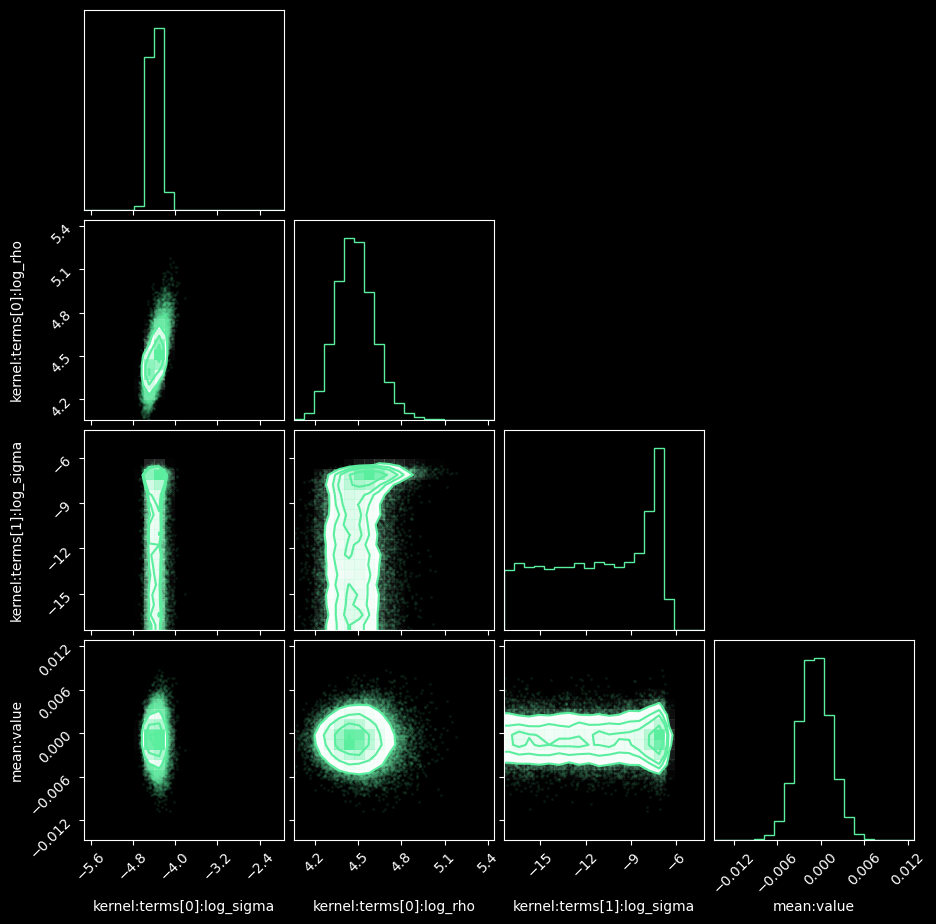

The initial parameter vector is [ 0.00000000e+00  6.20132379e+00 -4.53919253e+00 -2.28835863e-18]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 72.90it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 68.65it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:09<00:00, 72.13it/s]


The array of autocorrelation times is [68.85316803 53.66249554 61.6729229  49.84671544]


<Figure size 640x480 with 0 Axes>

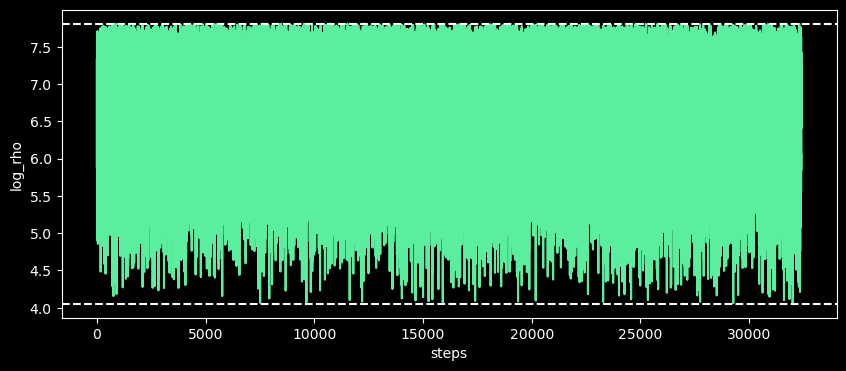

The bounds returned by the attribute are [(-15, 15), (4.053621246253011, 7.810761705902729), (-15, 15), (None, None)]
The 0th lower bound was breached, reaching a min. of -29.92
The 2nd lower bound was breached, reaching a min. of -30.00


<Figure size 640x480 with 0 Axes>

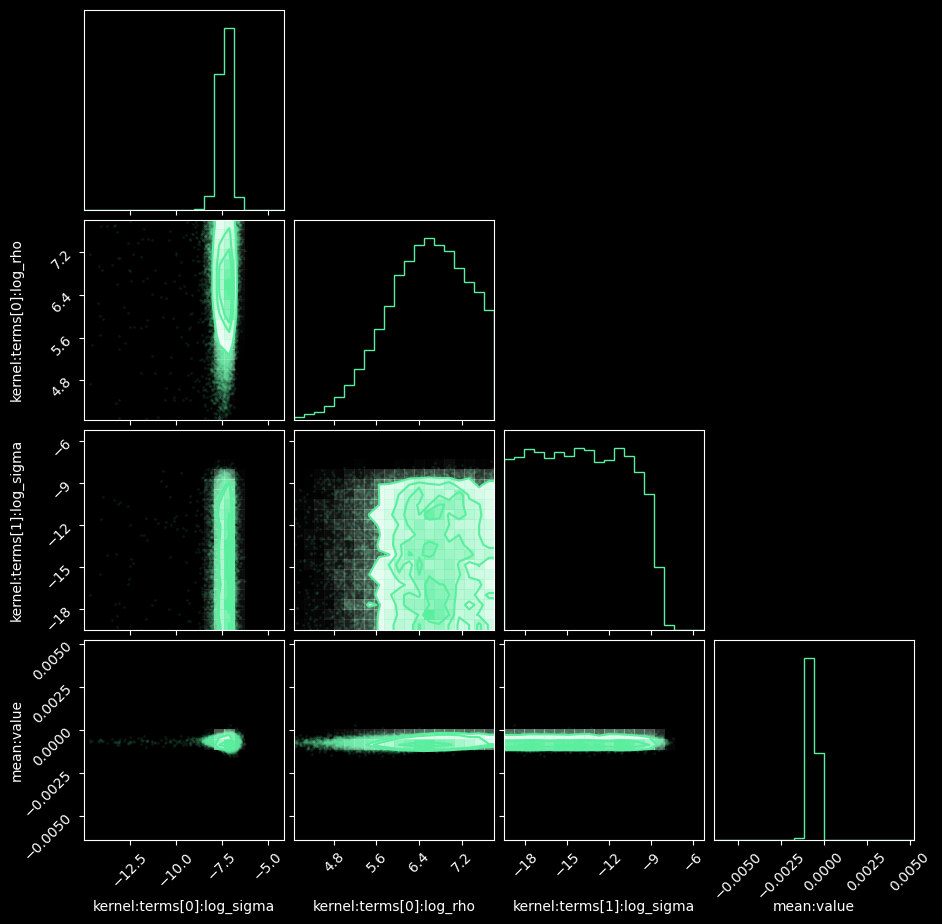

The initial parameter vector is [ 0.00000000e+00  6.20132379e+00 -4.62895743e+00 -9.78088768e-19]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 72.69it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 68.23it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:03<00:00, 79.08it/s]


The array of autocorrelation times is [87.23867268 79.62420003 88.09244655 69.37118376]


<Figure size 640x480 with 0 Axes>

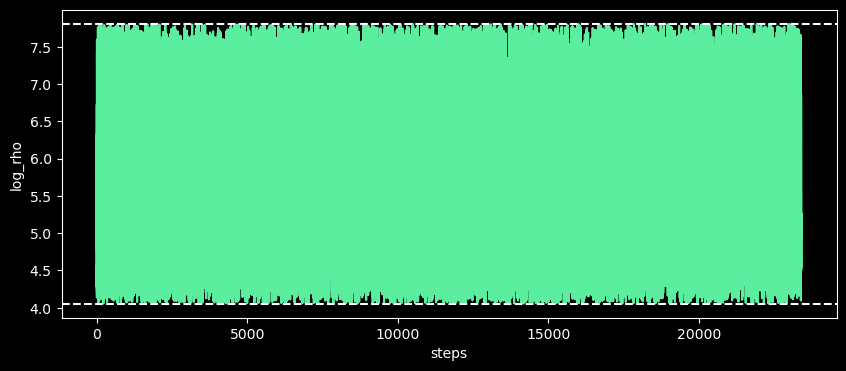

The bounds returned by the attribute are [(-15, 15), (4.053621246253011, 7.810761705902729), (-15, 15), (None, None)]
The 0th lower bound was breached, reaching a min. of -30.00
The 2nd lower bound was breached, reaching a min. of -30.00


<Figure size 640x480 with 0 Axes>

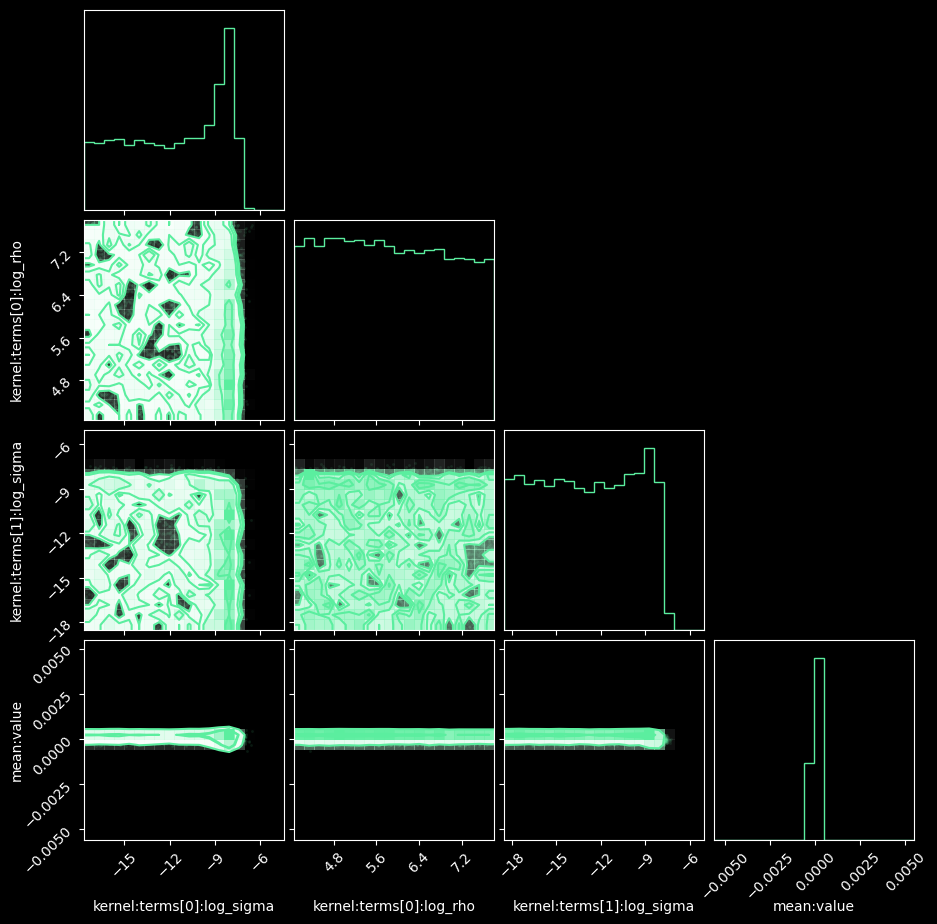

ValueError: operands could not be broadcast together with shapes (376,) (376,30) 

In [10]:
read_old = False
gp_file = os.path.join(data_dir, '{}_gps_fin.npz'.format(psr))
if read_old and os.path.exists(gp_file):
    with np.load(gp_file) as d:
        if exist_DFB and 'DFB_mjds_pred' in d.keys():
            DFB_mjds_pred = d['DFB_mjds_pred']
            DFB_pred_vars = d['DFB_vars_pred']
            DFB_pred_res = d['DFB_res_pred']
        else:
            print("No DFB arrays in npz file")
            
        if exist_AFB and 'AFB_mjds_pred' in d.keys():
            AFB_mjds_pred = d['AFB_mjds_pred']
            AFB_pred_vars = d['AFB_vars_pred']
            AFB_pred_res = d['AFB_res_pred']
        else:
            print("No AFB arrays in npz file")
            
if exist_DFB and 'DFB_pred_res' not in locals():
    print("Running GP for DFB data")
    lags = DFB_mjds[1:] - DFB_mjds[:-1]
    pmin = np.percentile(lags, 97.5)
    print("The minimum length scale for DFB is {:.2f}".format(pmin))
    mjd_range = DFB_mjds[-1] - DFB_mjds[0]
    kern_len = max(pmin*2, mjd_range/10)

    DFB_pred_res, DFB_pred_vars, DFB_mjds_pred = run_each_gp(DFB_eigval, DFB_mjds, DFB_errs, kern_len=kern_len, max_num=3, # adjust this number as necessary
                                                             prior_min=pmin, prior_max=0.5*mjd_range, mjds_pred=DFB_mjds_pred,
                                                             burn_chain=300, prod_chain=5000, num_walkers=200, # these values can be adjusted but should work
                                                             plot_chains=True, plot_corner=True, plot_gps=True, mcmc=True, multi=True,
                                                             verb=True, bk_bgd=use_bk_bgd, gp_plotname=os.path.join(plots_dir, psr+'_dfb_{}_gp_preds.png'.format(freq)))


In [ ]:
 if os.path.exists('gp_init_threads.py'):
    os.remove('gp_init_threads.py')
    
if exist_AFB and 'AFB_pred_res' not in locals():
    print("Running GP for AFB data")
    a_lags = AFB_mjds[1:] - AFB_mjds[:-1]
    a_pmin = np.percentile(a_lags, 97.5)
    print("The minimum length scale for AFB is {:.2f}".format(a_pmin))
    a_mjd_range = AFB_mjds[-1] - AFB_mjds[0]
    a_kern_len = max(a_pmin*2, a_mjd_range/10)

    AFB_pred_res, AFB_pred_vars, AFB_mjds_pred = run_each_gp(AFB_eigval, AFB_mjds, AFB_errs, kern_len=a_kern_len, max_num=4, # adjust this number as necessary
                                                             prior_min=a_pmin, prior_max=0.5*a_mjd_range, mjds_pred=AFB_mjds_pred,
                                                             burn_chain=300, prod_chain=5000, num_walkers=200, # these values can be adjusted but should work for most datasets
                                                             plot_chains=True, plot_corner=True, plot_gps=True, mcmc=True, multi=True,
                                                             verb=True, bk_bgd=use_bk_bgd, gp_plotname=os.path.join(plots_dir, psr+'_afb_{}_gp_preds.png'.format(freq)))


In [ ]:
if exist_DFB:
    plot_recon_profs(DFB_mean, DFB_eigvec, DFB_mjds_pred, DFB_pred_res, psr, mjds_real=DFB_mjds, bk_bgd=use_bk_bgd,
                     sub_mean=True, savename=os.path.join(plots_dir, psr+'_dfb_recon_wfall.png'))
    

In [ ]:
if exist_AFB:
    plot_recon_profs(AFB_mean, AFB_eigvec, AFB_mjds_pred, AFB_pred_res, psr, mjds_real=AFB_mjds, bk_bgd=use_bk_bgd,
                     sub_mean=True, savename=os.path.join(plots_dir, psr+'_afb_recon_wfall.png'))
    

We want to save the arrays containing GP predicted values, so the following cells will check if an older file exists (which may contain arrays for different datasets), read that into a separate dictionary, and write both dictionaries to the '.npz' file. 

In [ ]:
var_dict = {}
if exist_DFB:
    var_dict['DFB_mjds_pred'] = DFB_mjds_pred
    var_dict['DFB_res_pred'] = DFB_pred_res
    var_dict['DFB_vars_pred'] = DFB_pred_vars
    
if exist_AFB:
    var_dict['AFB_mjds_pred'] = AFB_mjds_pred
    var_dict['AFB_res_pred'] = AFB_pred_res
    var_dict['AFB_vars_pred'] = AFB_pred_vars


In [ ]:
out_file = os.path.join(data_dir, '{}_gps_fin.npz'.format(psr))
old_dict = {}
if os.path.exists(out_file):
    with np.load(out_file) as f:
        for key in f.keys():
            if key not in var_dict.keys():
                old_dict[key] = f[key]
            else:
                print("Replacing an older value for "+key)
                
np.savez(out_file, **var_dict, **old_dict)
